In [ ]:
# ==========================================================
# 🧠 CIFAR-10 Image Classification using CNN & Transfer Learning
# ==========================================================

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## 🧠 The CIFAR-10 Dataset

The **CIFAR-10** dataset is a classic computer vision benchmark with **60,000 color images (32×32)** in **10 classes**, each containing **6,000 images**.

- **Training images:** 50,000  
- **Test images:** 10,000  

### 📦 Dataset Structure
- **5 training batches** + **1 test batch**
- **1,000 test images per class**
- **5,000 training images per class**

Each image belongs to one of the following classes:

`airplane`, `automobile`, `bird`, `cat`, `deer`, `dog`, `frog`, `horse`, `ship`, `truck`.


In [ ]:
# ==========================================================
# ⚙️ Setup & Imports
# ==========================================================

# Reproducibility
import os, random
import numpy as np
import tensorflow as tf

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Core Libraries
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)

# Transfer Learning Imports
from tensorflow.keras.applications import MobileNetV2, NASNetMobile
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.nasnet import preprocess_input as nasnet_preprocess

# CIFAR-10 Class Names
CLASS_NAMES = ["airplane","automobile","bird","cat","deer",
               "dog","frog","horse","ship","truck"]


## 📥 Data Loading & Preprocessing
We load the CIFAR-10 dataset once and prepare two versions:
- **Raw (0-255)** — used for pretrained models (`MobileNetV2`, `NASNetMobile`)
- **Normalized (0-1)** — used for the custom CNN models


In [ ]:
# ==========================================================
# 📥 Load Dataset
# ==========================================================
(X_train_raw, y_train), (X_test_raw, y_test) = keras.datasets.cifar10.load_data()
y_train, y_test = y_train.flatten(), y_test.flatten()

# Normalized copy for CNNs
X_train_cnn = X_train_raw.astype("float32") / 255.0
X_test_cnn  = X_test_raw.astype("float32") / 255.0

print(f"Train: {X_train_raw.shape} | Test: {X_test_raw.shape}")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
Train: (50000, 32, 32, 3) | Test: (10000, 32, 32, 3)


## 👀 Data Visualization
Let's look at a few sample images with their corresponding labels.


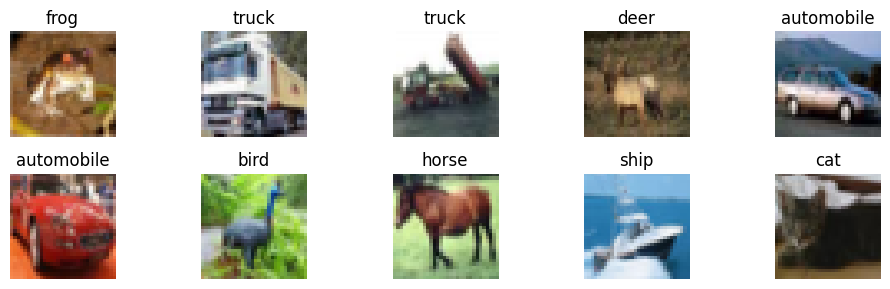

In [ ]:
plt.figure(figsize=(10,3))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train_raw[i])
    plt.title(CLASS_NAMES[y_train[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()


## 🧮 Evaluation Helper
To avoid code repetition, we define a reusable function that prints:
- Accuracy, Precision, Recall, F1-score  
- Full classification report  
- One **non-normalized** confusion matrix


In [ ]:
def evaluate_and_report(model, X, y, class_names, title_prefix=""):
    """Compute and display classification metrics + confusion matrix."""
    y_pred_probs = model.predict(X, verbose=0)
    y_pred = y_pred_probs.argmax(axis=1)

    acc  = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, average='weighted', zero_division=0)
    rec  = recall_score(y, y_pred, average='weighted', zero_division=0)
    f1   = f1_score(y, y_pred, average='weighted', zero_division=0)

    print(f"{title_prefix}Accuracy={acc:.4f}")
    print(f"{title_prefix}Precision={prec:.4f}")
    print(f"{title_prefix}Recall={rec:.4f}")
    print(f"{title_prefix}F1 Score={f1:.4f}")

    print(f"\n--- Classification Report {title_prefix.strip()} ---")
    print(classification_report(y, y_pred, target_names=class_names, zero_division=0))

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{title_prefix}Confusion Matrix (Counts)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()


## 🧩 Baseline CNN
A simple convolutional network trained from scratch.


Epoch 1/20
625/625 - 8s - 13ms/step - accuracy: 0.3806 - loss: 1.6761 - val_accuracy: 0.5346 - val_loss: 1.3450
Epoch 2/20
625/625 - 2s - 4ms/step - accuracy: 0.5087 - loss: 1.3545 - val_accuracy: 0.5948 - val_loss: 1.1745
Epoch 3/20
625/625 - 2s - 4ms/step - accuracy: 0.5620 - loss: 1.2236 - val_accuracy: 0.6244 - val_loss: 1.0731
Epoch 4/20
625/625 - 2s - 4ms/step - accuracy: 0.5910 - loss: 1.1459 - val_accuracy: 0.6454 - val_loss: 1.0108
Epoch 5/20
625/625 - 2s - 4ms/step - accuracy: 0.6163 - loss: 1.0804 - val_accuracy: 0.6567 - val_loss: 0.9820
Epoch 6/20
625/625 - 2s - 4ms/step - accuracy: 0.6344 - loss: 1.0258 - val_accuracy: 0.6620 - val_loss: 0.9733
Epoch 7/20
625/625 - 2s - 4ms/step - accuracy: 0.6524 - loss: 0.9784 - val_accuracy: 0.6698 - val_loss: 0.9564
Epoch 8/20
625/625 - 2s - 4ms/step - accuracy: 0.6604 - loss: 0.9443 - val_accuracy: 0.6850 - val_loss: 0.9111
Epoch 9/20
625/625 - 2s - 4ms/step - accuracy: 0.6784 - loss: 0.9026 - val_accuracy: 0.6941 - val_loss: 0.8955


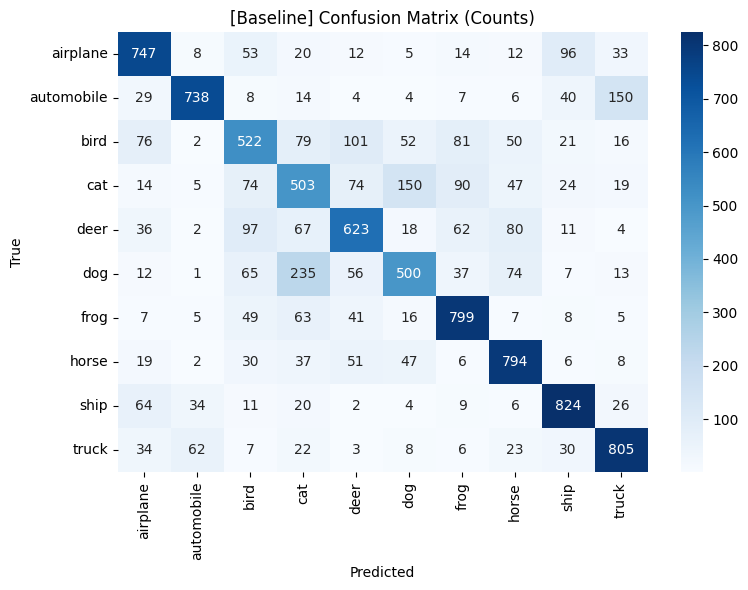

In [ ]:
baseline = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(10, activation="softmax")
], name="cnn_baseline")

baseline.compile(optimizer="adam",
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])

history_base = baseline.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)],
    verbose=2
)

print(f"[Baseline CNN] Test acc: {baseline.evaluate(X_test_cnn, y_test, verbose=0)[1]:.4f}")
evaluate_and_report(baseline, X_test_cnn, y_test, CLASS_NAMES, title_prefix="[Baseline] ")


## ⚙️ Fine-Tuned CNN (BatchNorm + GAP)
Improved CNN with:
- Data augmentation  
- Batch Normalization  
- Global Average Pooling  
- L2 regularization  
- Early stopping + LR scheduler


Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.3884 - loss: 1.8666 - val_accuracy: 0.3038 - val_loss: 2.3877 - learning_rate: 8.0000e-04
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5864 - loss: 1.2855 - val_accuracy: 0.6297 - val_loss: 1.1504 - learning_rate: 8.0000e-04
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.6566 - loss: 1.0618 - val_accuracy: 0.6965 - val_loss: 0.9444 - learning_rate: 8.0000e-04
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.7017 - loss: 0.9191 - val_accuracy: 0.7201 - val_loss: 0.8662 - learning_rate: 8.0000e-04
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.7311 - loss: 0.8277 - val_accuracy: 0.7133 - val_loss: 0.8980 - learning_rate: 8.0000e-04
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.7558 - loss: 0.7531 - val_accuracy: 0.7572 - val_loss: 0.7474 - learning_rate: 8.0000e-04
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/ste

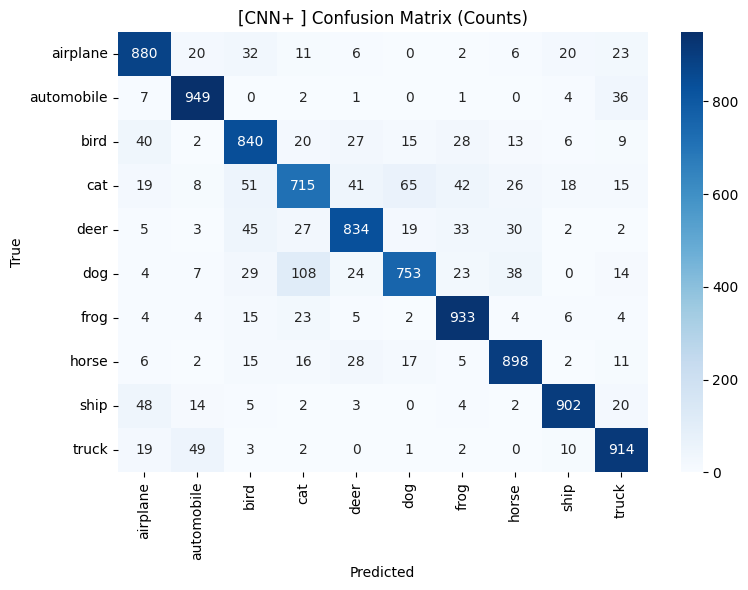

In [ ]:
from tensorflow.keras.regularizers import l2

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="augmentation")

def build_cnn_plus(num_classes=10):
    inputs = layers.Input(shape=(32, 32, 3))
    x = layers.Rescaling(1./255)(inputs)
    x = data_augmentation(x)

    for filters in [32, 64, 128]:
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(2)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation="relu", kernel_regularizer=l2(1e-3))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="cnn_cifar10_plus")

cnn_plus = build_cnn_plus()
cnn_plus.compile(optimizer=keras.optimizers.Adam(8e-4),
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])

history_plus = cnn_plus.fit(
    X_train_raw, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_test_raw, y_test),
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
    ],
    verbose=1
)

cnn_plus.save("/content/drive/MyDrive/cnn_cifar10_best.keras")
evaluate_and_report(cnn_plus, X_test_raw, y_test, CLASS_NAMES, title_prefix="[CNN+ ] ")


## 🚀 Transfer Learning: MobileNetV2
We fine-tune an ImageNet-pretrained **MobileNetV2**:
- Resize images to 160×160  
- Freeze backbone → warm-up  
- Unfreeze top layers → fine-tune


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/step - accuracy: 0.5818 - loss: 1.2250 - val_accuracy: 0.8272 - val_loss: 0.4913
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.7409 - loss: 0.7596 - val_accuracy: 0.8348 - val_loss: 0.4792
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.7528 - loss: 0.7137 - val_accuracy: 0.8346 - val_loss: 0.4702
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.7610 - loss: 0.6982 - val_accuracy: 0.8440 - val_loss: 0.4468
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.7602 - loss: 0.6950 - val_accuracy: 0.8460 - val_loss: 0.4471
Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 63s 78ms/step - accuracy: 0.7443 - loss: 0.7838 - val_accuracy: 0.8596 - val_loss: 0.4853
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 53s 76ms/step - accuracy: 0.8430 - loss: 0.4509 - val_accuracy: 0.8742 - val_loss: 0.4192
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 53s 76ms/

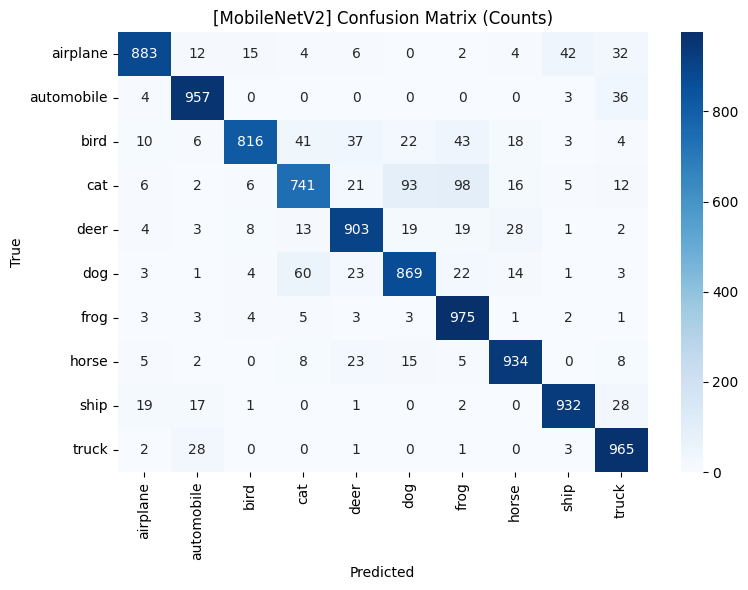

In [ ]:
TARGET = 160
base = MobileNetV2(include_top=False, weights="imagenet", input_shape=(TARGET, TARGET, 3))
base.trainable = False

mobilenet_model = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.Resizing(TARGET, TARGET),
    layers.Lambda(mobilenet_preprocess),
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(10, activation="softmax")
], name="mobilenetv2_tl")

mobilenet_model.compile(optimizer=keras.optimizers.Adam(1e-3),
                        loss="sparse_categorical_crossentropy",
                        metrics=["accuracy"])

mobilenet_model.fit(X_train_raw, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)
base.trainable = True
for layer in base.layers[:-30]:
    layer.trainable = False

mobilenet_model.compile(optimizer=keras.optimizers.Adam(1e-4),
                        loss="sparse_categorical_crossentropy",
                        metrics=["accuracy"])

mobilenet_model.fit(X_train_raw, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)
mobilenet_model.save("/content/drive/MyDrive/MobileNetV2_cifar10_best.keras")

evaluate_and_report(mobilenet_model, X_test_raw, y_test, CLASS_NAMES, title_prefix="[MobileNetV2] ")


## 🚀 Transfer Learning: NASNetMobile
Similar to MobileNetV2, we apply transfer learning using **NASNetMobile**:
- Resize to 224×224  
- Pretrained ImageNet backbone  
- Warm-up + fine-tune


19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 131s 161ms/step - accuracy: 0.5981 - loss: 1.1684 - val_accuracy: 0.8438 - val_loss: 0.4602
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 106s 150ms/step - accuracy: 0.7345 - loss: 0.7650 - val_accuracy: 0.8524 - val_loss: 0.4345
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 106s 150ms/step - accuracy: 0.7496 - loss: 0.7211 - val_accuracy: 0.8514 - val_loss: 0.4252
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 106s 150ms/step - accuracy: 0.7491 - loss: 0.7170 - val_accuracy: 0.8534 - val_loss: 0.4215
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 106s 150ms/step - accuracy: 0.7478 - loss: 0.7183 - val_accuracy: 0.8566 - val_loss: 0.4218
Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 134s 163ms/step - accuracy: 0.7569 - loss: 0.6978 - val_accuracy: 0.8616 - val_loss: 0.4015
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 109s 155ms/step - accuracy: 0.7683 - loss: 0.6662 - val_accuracy: 0.8608 - val_loss: 0.3970
Epoch 3/5
704/704 ━━━━━━━━━━━━━━

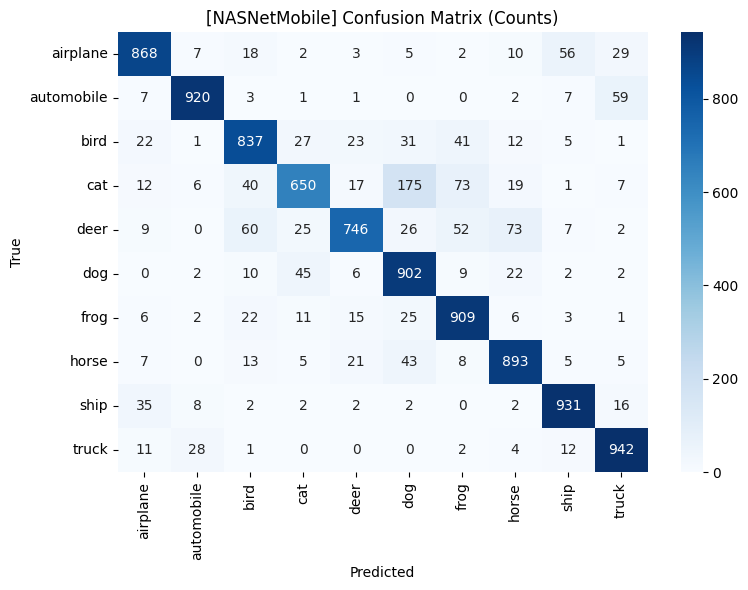

In [ ]:
NAS_TARGET = 224
nas_base = NASNetMobile(include_top=False, weights="imagenet", input_shape=(NAS_TARGET, NAS_TARGET, 3))
nas_base.trainable = False

nasnet_model = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.Resizing(NAS_TARGET, NAS_TARGET),
    layers.Lambda(nasnet_preprocess),
    nas_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.25),
    layers.Dense(10, activation="softmax")
], name="nasnetmobile_tl")

nasnet_model.compile(optimizer=keras.optimizers.Adam(1e-3),
                     loss="sparse_categorical_crossentropy",
                     metrics=["accuracy"])

nasnet_model.fit(X_train_raw, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)

nas_base.trainable = True
for layer in nas_base.layers[:-20]:
    layer.trainable = False

nasnet_model.compile(optimizer=keras.optimizers.Adam(1e-4),
                     loss="sparse_categorical_crossentropy",
                     metrics=["accuracy"])

nasnet_model.fit(X_train_raw, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)
nasnet_model.save("/content/drive/MyDrive/NASNetMobile_cifar10_best.keras")

evaluate_and_report(nasnet_model, X_test_raw, y_test, CLASS_NAMES, title_prefix="[NASNetMobile] ")


## 📊 Performance Comparison

,Accuracy,Precision,Recall,F1 Score
Baseline CNN,0.6855,0.6849,0.6855,0.6833
CNN+ (BN+GAP),0.8618,0.8612,0.8618,0.8607
MobileNetV2 TL,0.8975,0.8992,0.8975,0.8966
NASNetMobile TL,0.8598,0.8628,0.8598,0.8582



Markdown table:

|                 |   Accuracy |   Precision |   Recall |   F1 Score |
|:----------------|-----------:|------------:|---------:|-----------:|
| Baseline CNN    |     0.6855 |      0.6849 |   0.6855 |     0.6833 |
| CNN+ (BN+GAP)   |     0.8618 |      0.8612 |   0.8618 |     0.8607 |
| MobileNetV2 TL  |     0.8975 |      0.8992 |   0.8975 |     0.8966 |
| NASNetMobile TL |     0.8598 |      0.8628 |   0.8598 |     0.8582 |


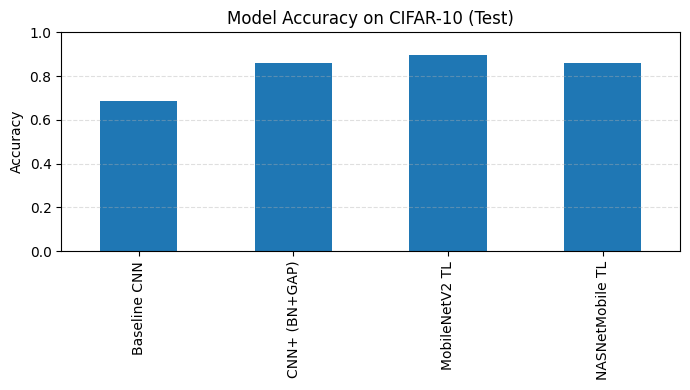

In [ ]:
# ==========================================
# 📊 Performance Comparison (auto-computed)
# ==========================================
from collections import OrderedDict

def compute_metrics(model, X, y):
    """Return dict with accuracy, precision, recall, f1 (weighted)."""
    y_pred = model.predict(X, verbose=0).argmax(axis=1)
    return {
        "Accuracy":  accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred, average='weighted', zero_division=0),
        "Recall":    recall_score(y, y_pred, average='weighted', zero_division=0),
        "F1 Score":  f1_score(y, y_pred, average='weighted', zero_division=0),
    }

# Compute with the correct inputs each model expects
results = OrderedDict()
results["Baseline CNN"]    = compute_metrics(baseline,        X_test_cnn,  y_test)
results["CNN+ (BN+GAP)"]   = compute_metrics(cnn_plus,        X_test_raw,  y_test)
results["MobileNetV2 TL"]  = compute_metrics(mobilenet_model, X_test_raw,  y_test)
results["NASNetMobile TL"] = compute_metrics(nasnet_model,    X_test_raw,  y_test)

import pandas as pd
df = pd.DataFrame(results).T
df = df[["Accuracy","Precision","Recall","F1 Score"]].round(4)
display(df)

# Table Report
print("\nMarkdown table:\n")
print(df.to_markdown(index=True))

# 🔎 Simple bar chart for Accuracy
plt.figure(figsize=(7,4))
df["Accuracy"].plot(kind="bar")
plt.title("Model Accuracy on CIFAR-10 (Test)")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


##🎯 Key Takeaways

Transfer Learning consistently outperformed scratch-built CNNs, demonstrating the benefit of pretrained ImageNet features.

The improved CNN+ model shows that architectural tuning + regularization can significantly boost performance even without pretrained weights.

Confusion matrix analysis reveals that animal classes are the hardest, while vehicles are the easiest across all models.

Fine-tuning (warm-up → unfreeze → small LR) is essential to get the best performance from transfer learning models.

##🏁 Final Remarks

This project highlights the power of systematically improving model complexity:

Baseline CNN → CNN+ → Transfer Learning

Each step brought meaningful performance gains. The results illustrate how modern pretrained architectures can dramatically improve accuracy on relatively small datasets such as CIFAR-10.